In [1]:
%load_ext autoreload
%autoreload 2

import jax  # noqa: I001
jax.config.update("jax_enable_x64", True)

import numpyro  # noqa: E402, I001
numpyro.set_host_device_count(4)

import h5py  # noqa: E402, I001
import numpy as np  # noqa: E402, I001
import ultraplot as uplt  # noqa: E402, I001
import corner  # noqa: E402
from matplotlib import pyplot as plt  # noqa: E402


Bad value in file PosixPath('/Users/beckermr/mambaforge/envs/des-y6/lib/python3.11/site-packages/arviz/plots/styles/arviz-grayscale.mplstyle'), line 33 ('image.cmap: cet_gray #  perceptually uniform gray scale from colorcet (linear_grey_10_95_c0)'): 'image.cmap is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'


In [2]:
v2_data = {k: [] for k in ["m", "dz", "nz"]}

with h5py.File("../2025_03_19_modeling_v2/des_y6_nz_SOMPZ_WZ_imsim_v2.1_num_bins9_w0p1_nonneg.h5", "r") as fp:
    for key in fp.keys():
        print(key)
        for ds in fp[key].keys():
            v2_data[ds].append(fp[key][ds][()])

for k in list(v2_data.keys()):
    v2_data[k] = np.concatenate(v2_data[k])

statistical
statistical-neighbor
statistical-neighbor-occupancy
statistical-occupancy


In [5]:
v3_data = {k: [] for k in ["m", "dz", "nz"]}

with h5py.File("des_y6_nz_SOMPZ_WZ_imsim_v3.1_nonneg.h5", "r") as fp:
    for key in fp.keys():
        for ds in fp[key].keys():
            v3_data[ds].append(fp[key][ds][()])

for k in list(v3_data.keys()):
    v3_data[k] = np.concatenate(v3_data[k])

Text(0.5, 0.98, '68% and 95% Contour Levels for v2 (black/solid) vs. v3 (red/dashed) Priors')

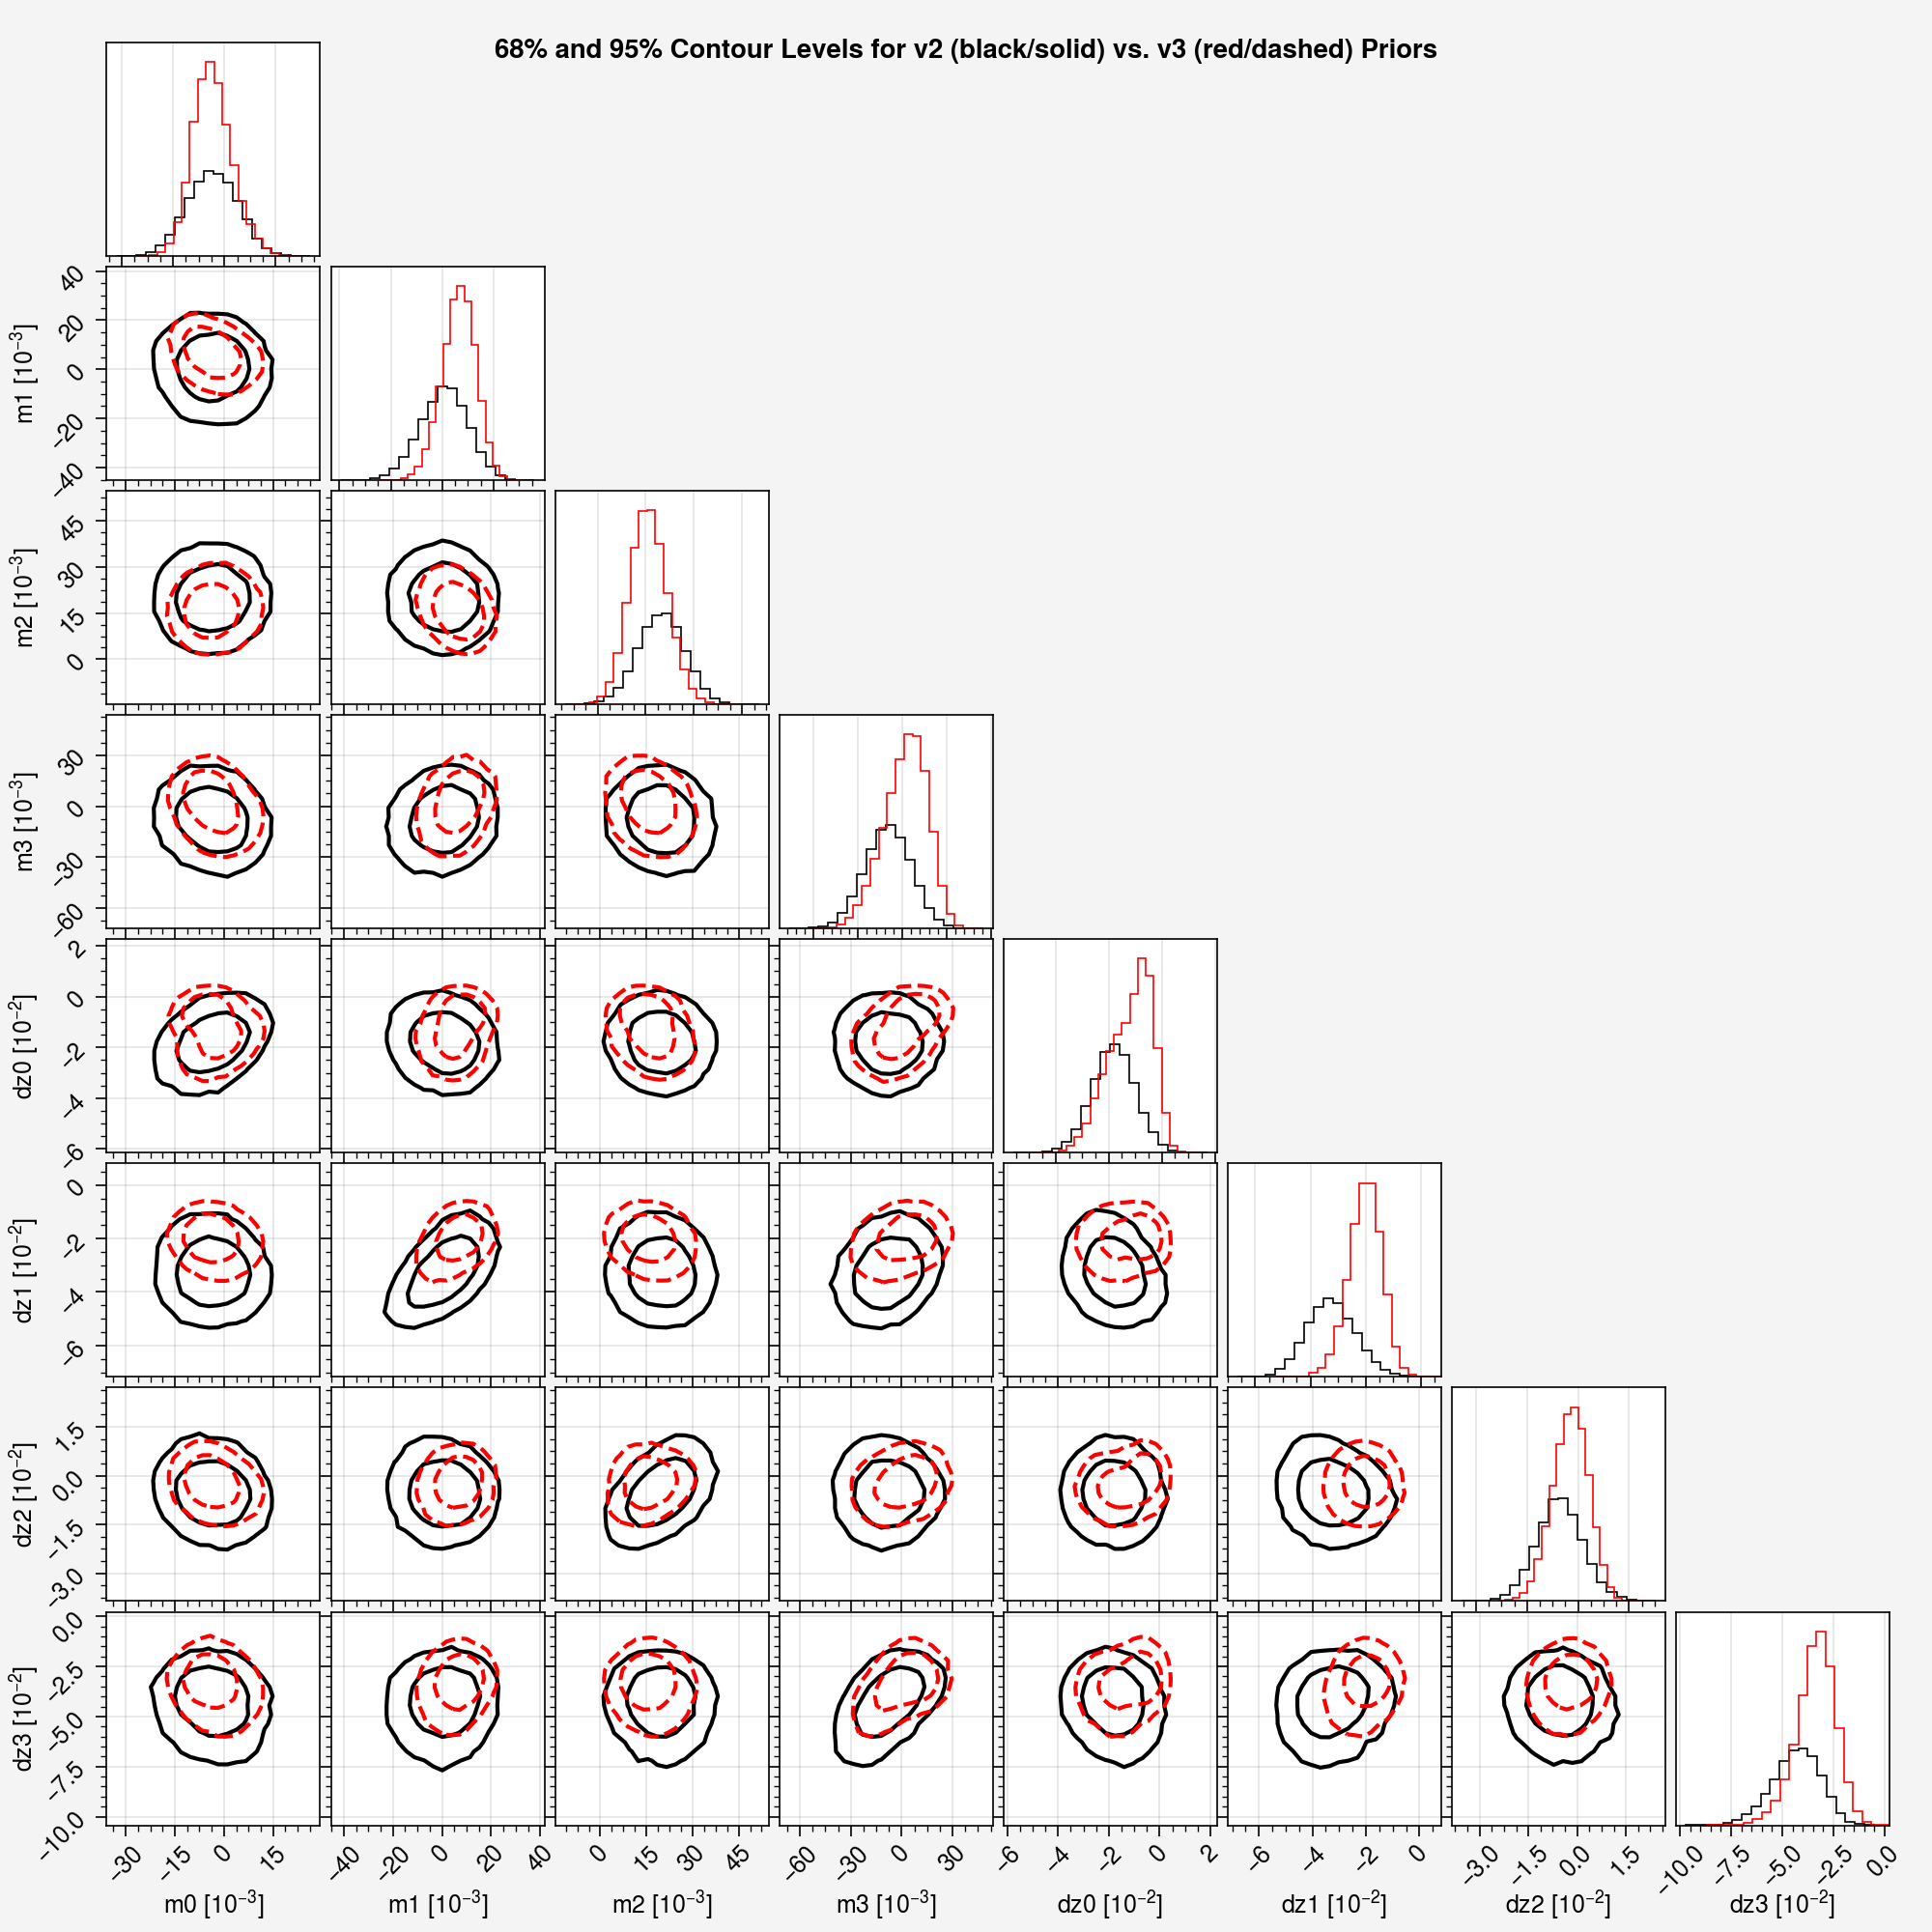

In [6]:
v2_total = np.concatenate([v2_data["m"]/1e-3, v2_data["dz"]/1e-2], axis=1)
v3_total = np.concatenate([v3_data["m"]/1e-3, v3_data["dz"]/1e-2], axis=1)
nd = v2_total.shape[1]
labels = [
    f"m{i} $[10^{{-3}}]$" for i in range(4)
] + [f"dz{i} $[10^{{-2}}]$" for i in range(4)]

fig, axs = plt.subplots(nrows=nd, ncols=nd, figsize=(10, 10))
corner.corner(
    v2_total,
    fig=fig,
    plot_datapoints=False,
    plot_density=False,
    levels=[0.68, 0.95],
    contour_kwargs={"colors": "k"},
    labels=labels,
    labelpad=0,
);
corner.corner(
    v3_total,
    fig=fig,
    plot_datapoints=False,
    plot_density=False,
    levels=[0.68, 0.95],
    color="r",
    contour_kwargs={"colors": "r", "linestyles": "dashed"},
);
fig.suptitle("68% and 95% Contour Levels for v2 (black/solid) vs. v3 (red/dashed) Priors")

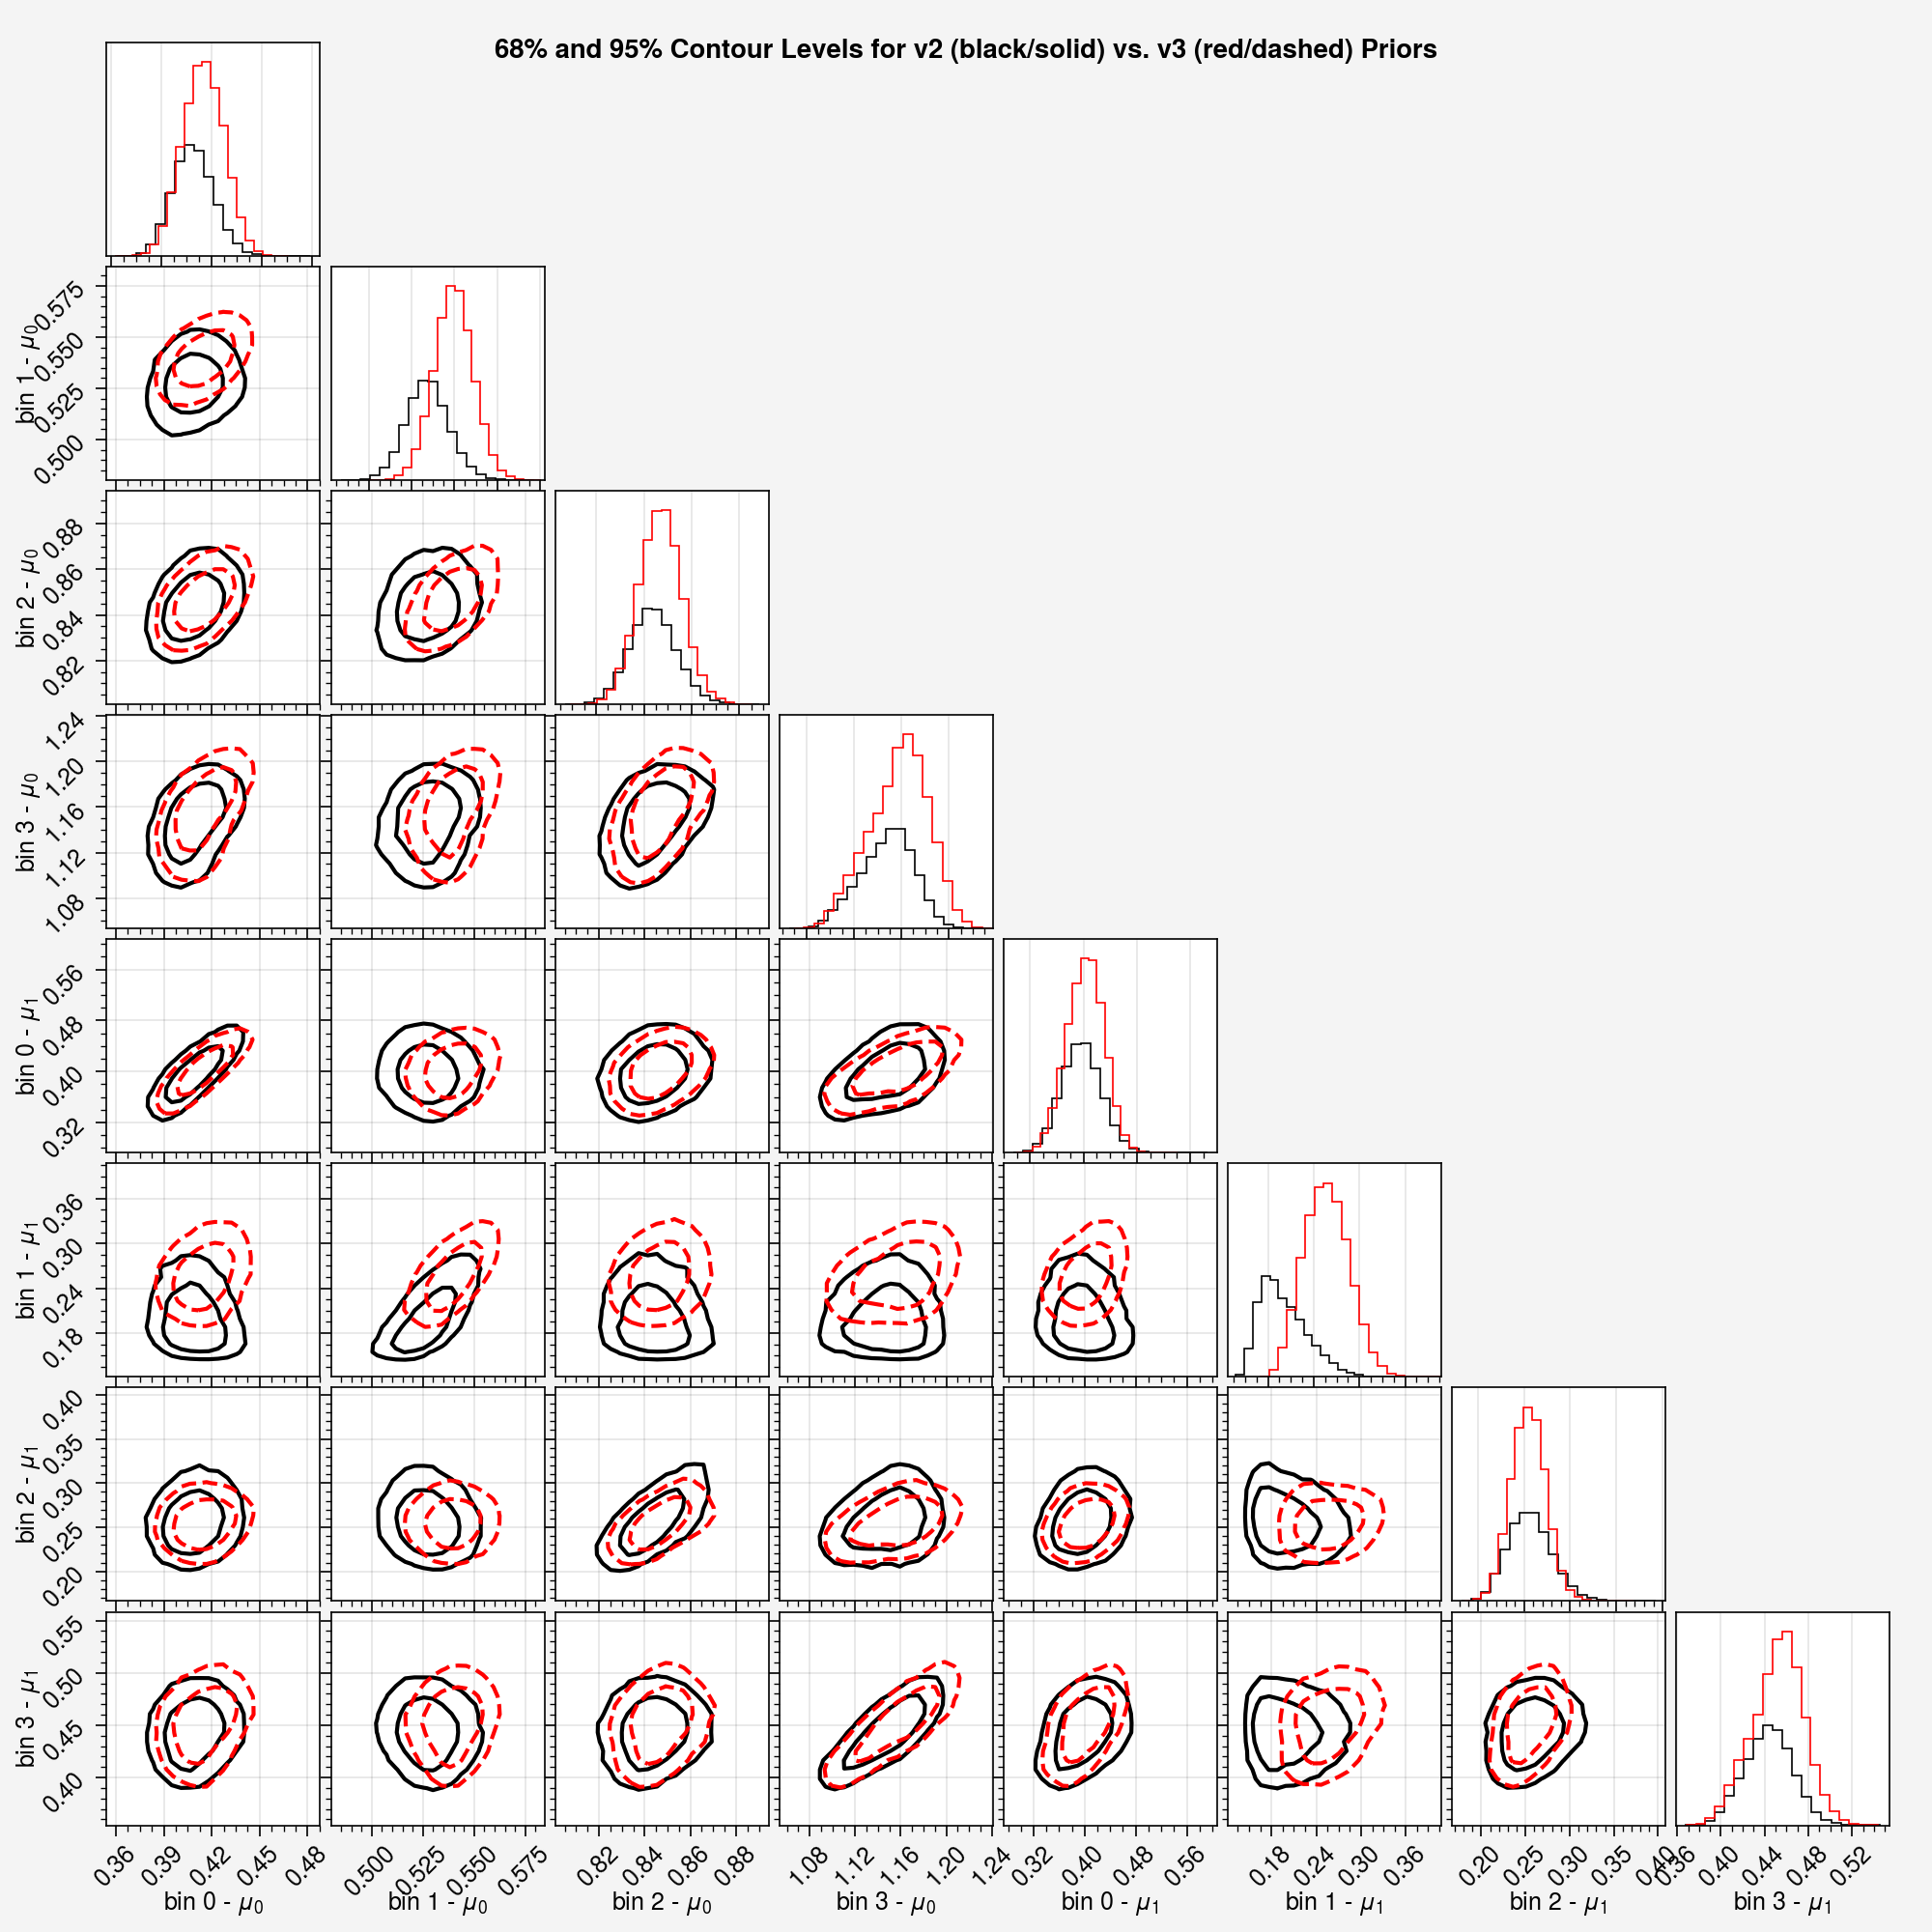

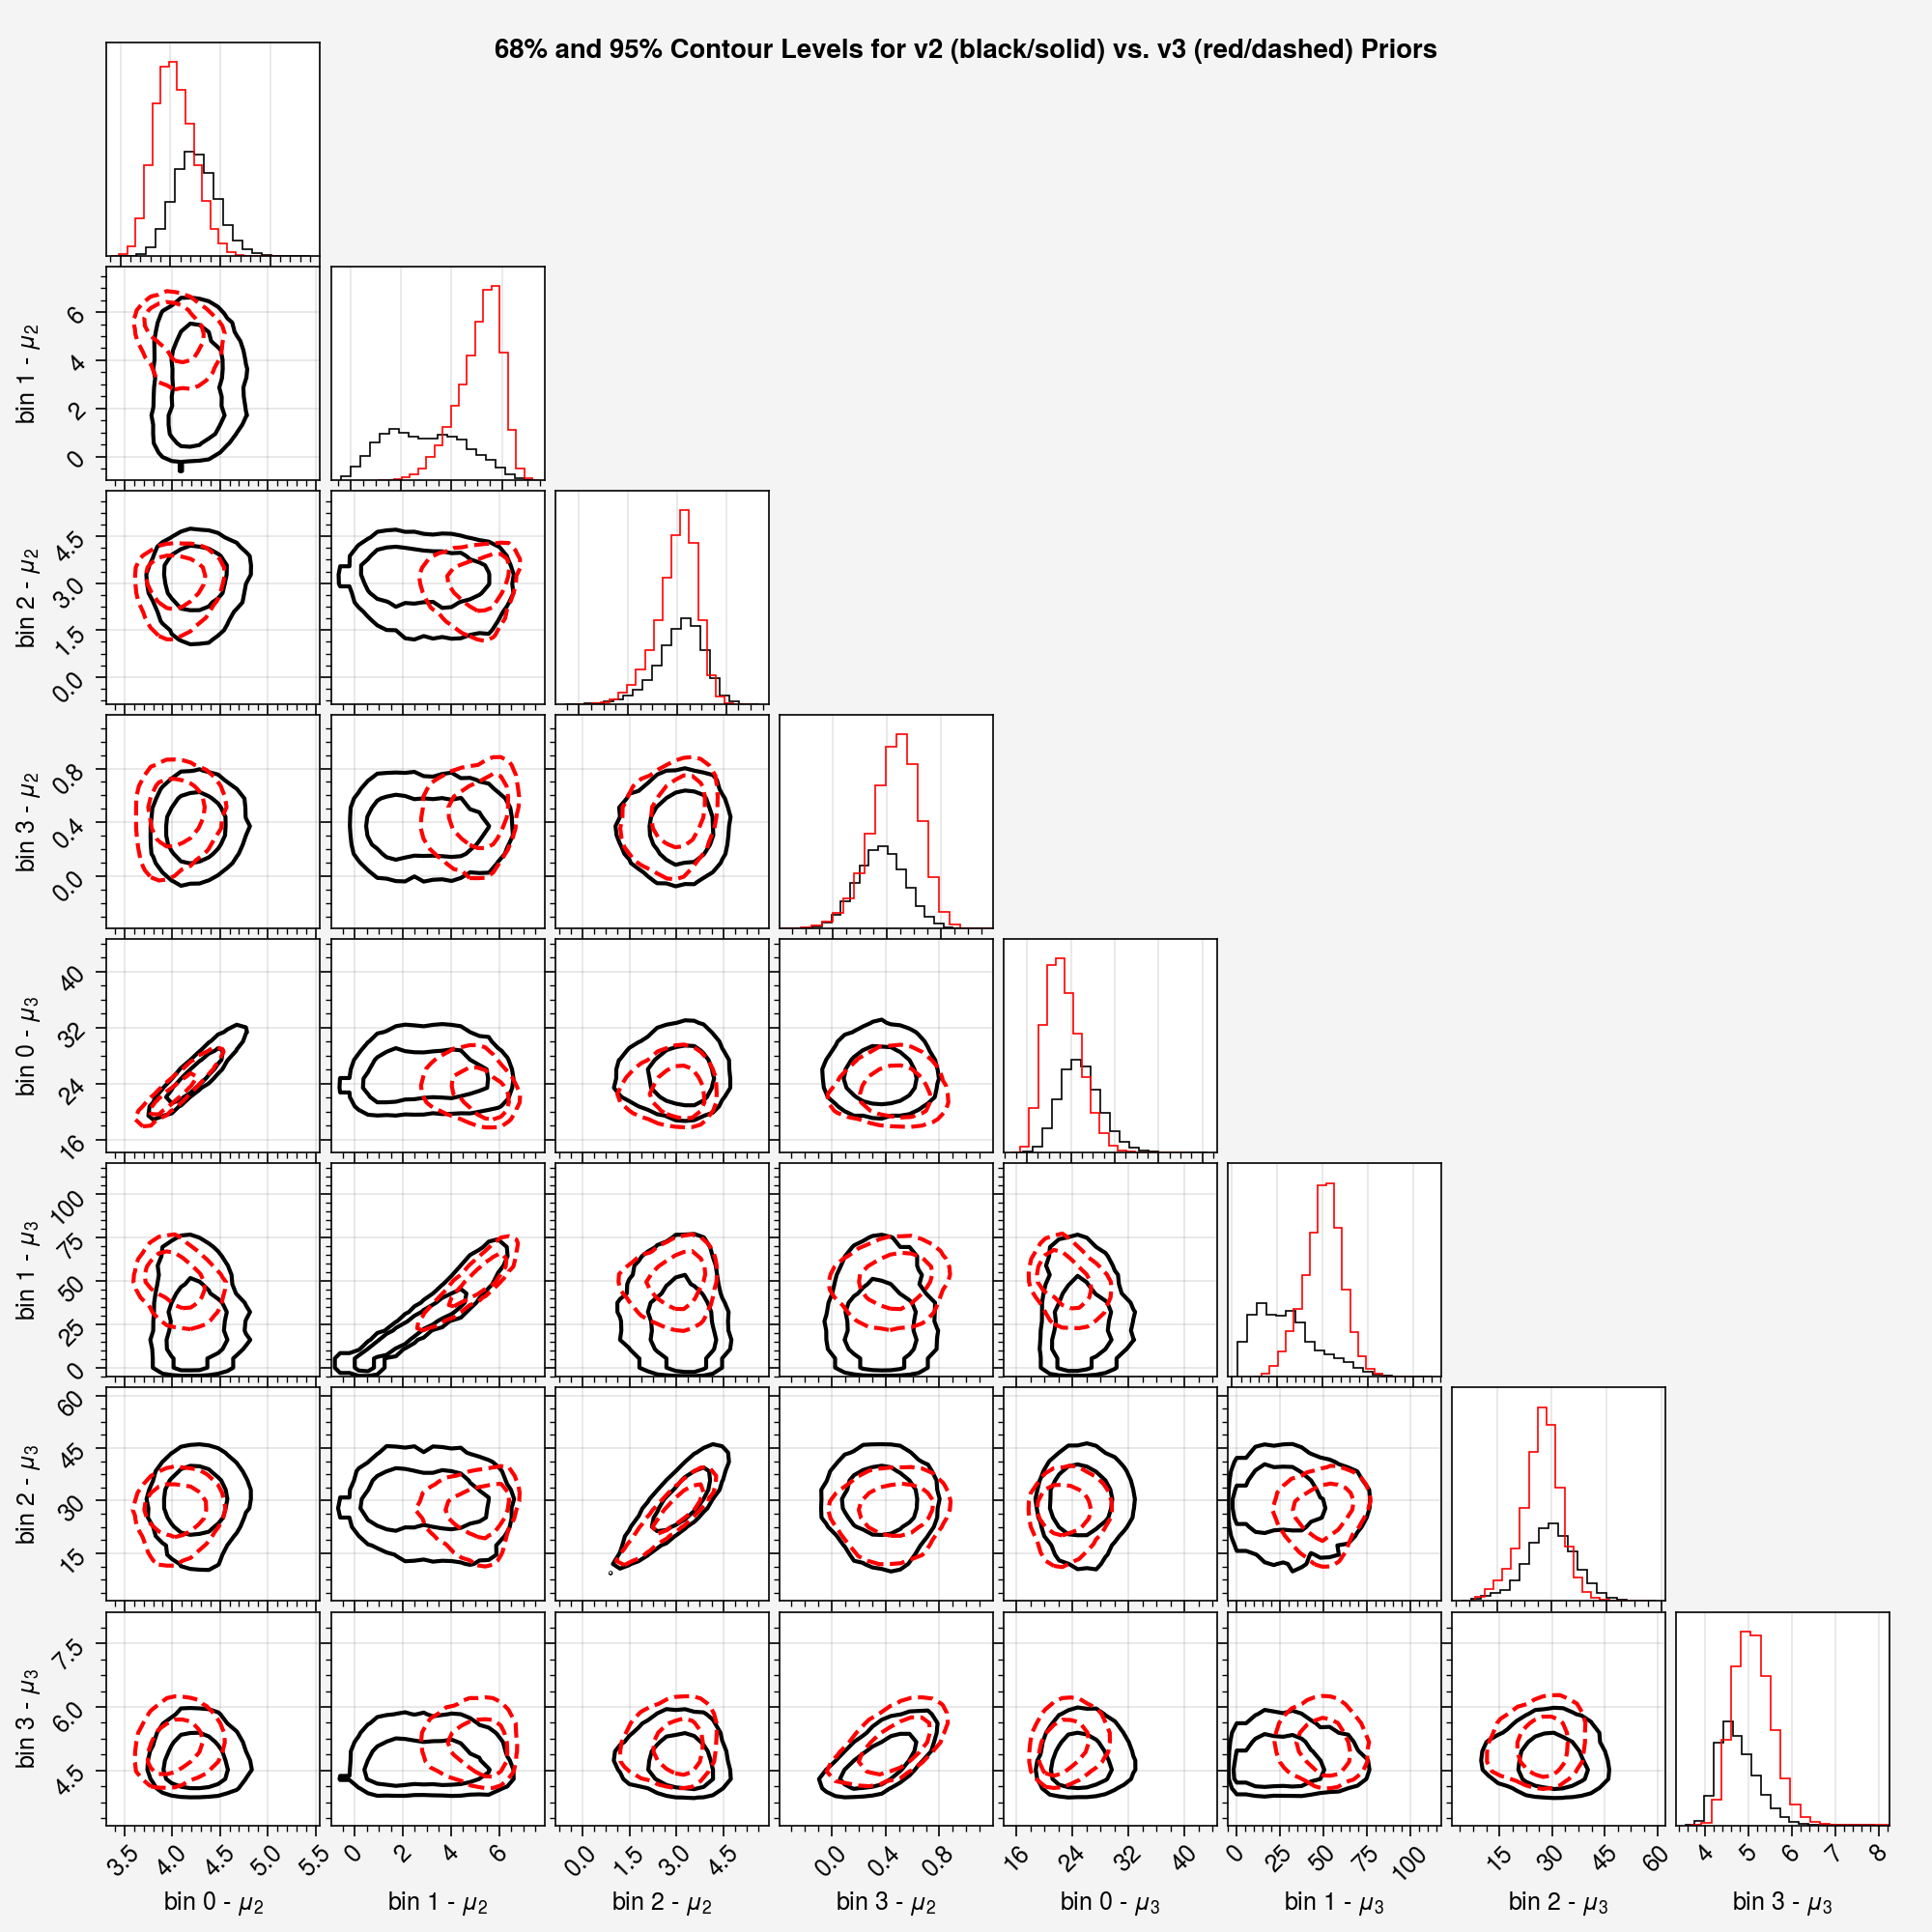

In [7]:
from des_y6_imsim_analysis.utils import GMODEL_COSMOS_Z


def _compute_moms(nz):
    """nz is shape (samples, tomobins, redshift)"""
    z = GMODEL_COSMOS_Z[1:-1]
    nrm = np.sum(nz, axis=-1, keepdims=True)
    mn = np.sum(nz * z, axis=-1, keepdims=True) / nrm
    sd = np.sqrt(np.sum(nz * (z - mn)**2, axis=-1, keepdims=True) / nrm)
    sk = np.sum(nz * (z - mn)**3, axis=-1, keepdims=True) / nrm / sd**3
    kt = np.sum(nz * (z - mn)**4, axis=-1, keepdims=True) / nrm / sd**4
    return mn[:, :, 0], sd[:, :, 0], sk[:, :, 0], kt[:, :, 0]


v2_moms = _compute_moms(v2_data["nz"])
v3_moms = _compute_moms(v3_data["nz"])

for ms in [0, 2]:
    minds = [ms, ms + 1]

    v2_total = np.concatenate(v2_moms[ms:ms + 2], axis=1)
    v3_total = np.concatenate(v3_moms[ms:ms + 2], axis=1)
    labels = [
        f"bin {i} - $\\mu_{ms}$" for i in range(4)
    ] + [
        f"bin {i} - $\\mu_{ms+1}$" for i in range(4)
    ]
    nd = v2_total.shape[1]

    fig, axs = plt.subplots(nrows=nd, ncols=nd, figsize=(10, 10))
    corner.corner(
        v2_total,
        fig=fig,
        plot_datapoints=False,
        plot_density=False,
        levels=[0.68, 0.95],
        color="k",
        contour_kwargs={"colors": "k"},
        labelpad=0,
        labels=labels,
    );
    corner.corner(
        v3_total,
        fig=fig,
        plot_datapoints=False,
        plot_density=False,
        levels=[0.68, 0.95],
        color="r",
        contour_kwargs={"colors": "r", "linestyles": "dashed"},
    );
    fig.suptitle("68% and 95% Contour Levels for v2 (black/solid) vs. v3 (red/dashed) Priors")

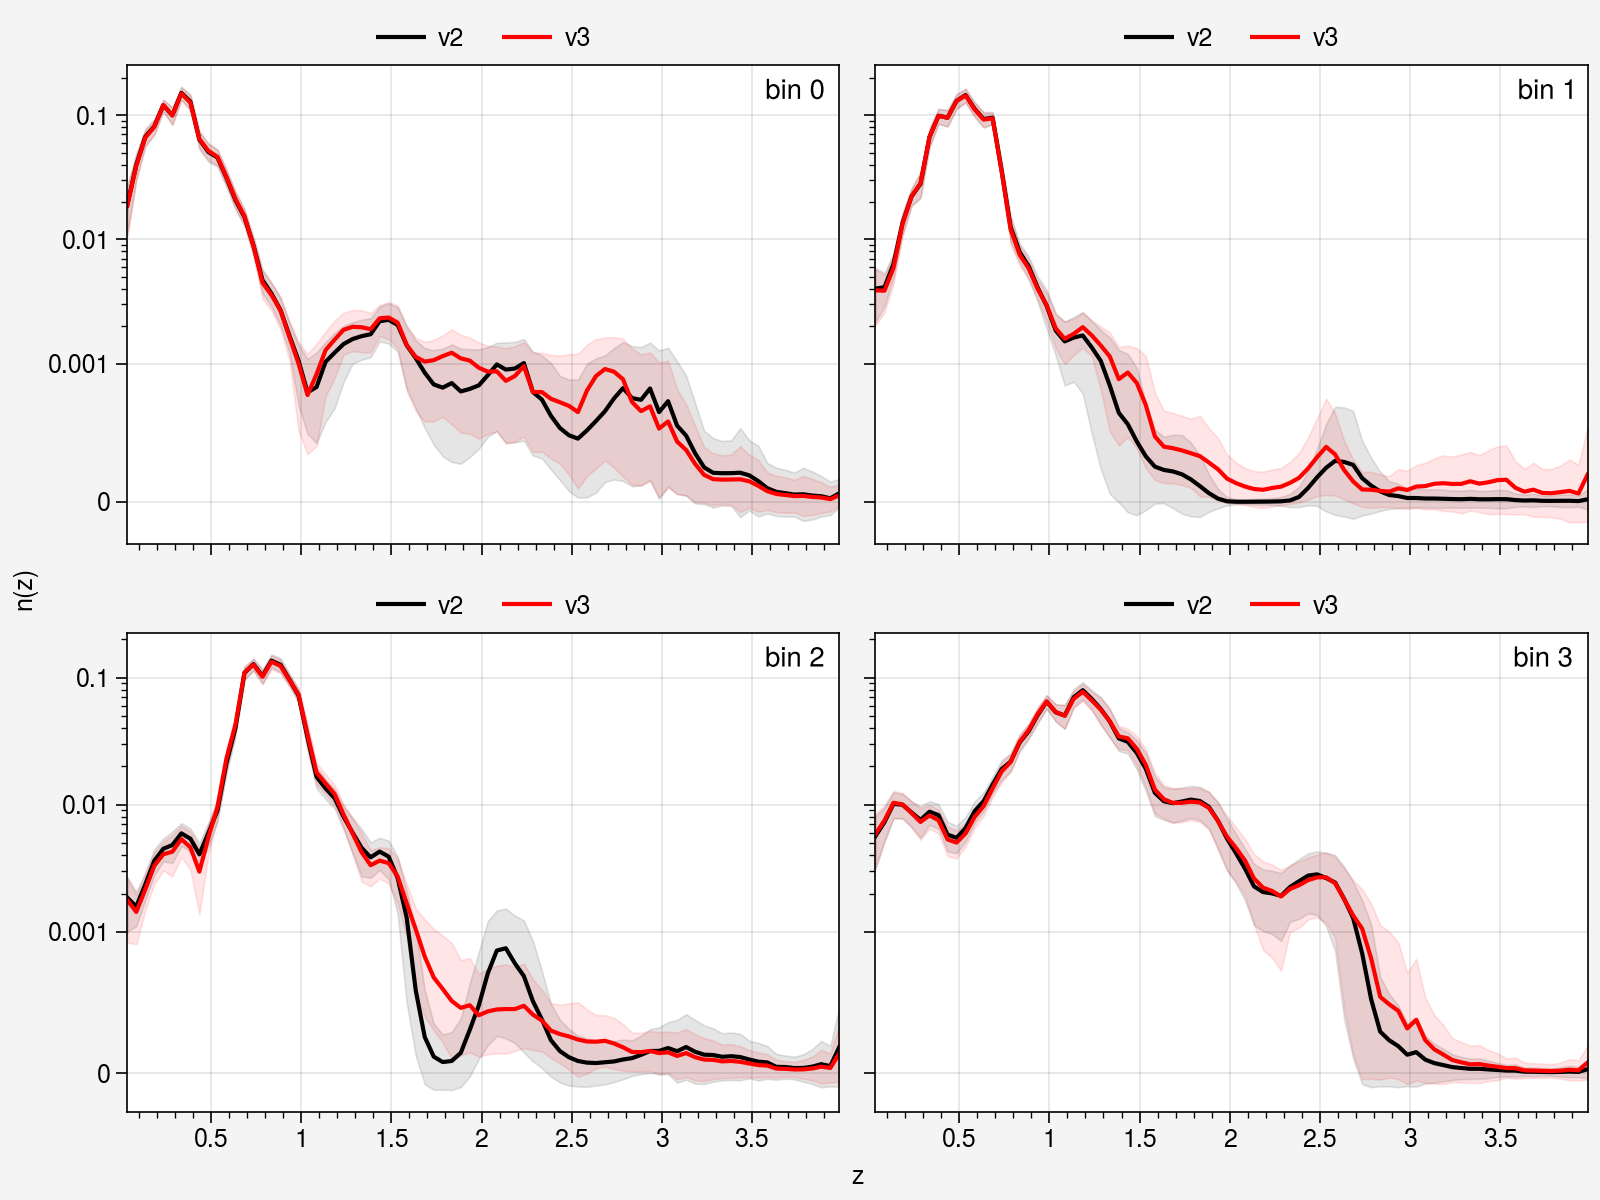

In [9]:
from des_y6_imsim_analysis.utils import GMODEL_COSMOS_Z

fig, axs = uplt.subplots(figsize=(8, 6), nrows=2, ncols=2)

v2_mn = np.mean(v2_data["nz"], axis=0)
v2_sd = np.std(v2_data["nz"], axis=0)
v3_mn = np.mean(v3_data["nz"], axis=0)
v3_sd = np.std(v3_data["nz"], axis=0)

bind = 0
for i in range(2):
    for j in range(2):
        ax = axs[i, j]

        ax.plot(
            GMODEL_COSMOS_Z[1:-1],
            v2_mn[bind, :],
            label="v2",
            color="k",
        )

        ax.fill_between(
            GMODEL_COSMOS_Z[1:-1],
            v2_mn[bind, :] - v2_sd[bind, :],
            v2_mn[bind, :] + v2_sd[bind, :],
            color="k",
            alpha=0.1,
        )

        ax.plot(
            GMODEL_COSMOS_Z[1:-1],
            v3_mn[bind, :] / np.sum(v3_mn[bind, :]),
            label="v3",
            color="r"
        )
        ax.fill_between(
            GMODEL_COSMOS_Z[1:-1],
            v3_mn[bind, :] - v3_sd[bind, :],
            v3_mn[bind, :] + v3_sd[bind, :],
            color="r",
            alpha=0.1,
        )

        ax.legend(loc="t", frameon=False)
        ax.set_yscale("symlog", linthresh=1e-3)
        ax.format(ylabel="n(z)", xlabel="z")
        fig.format(abc=[f"${{\\rm bin}}\\ {_bind}$" for _bind in range(4)], abcloc="ur")

        bind += 1

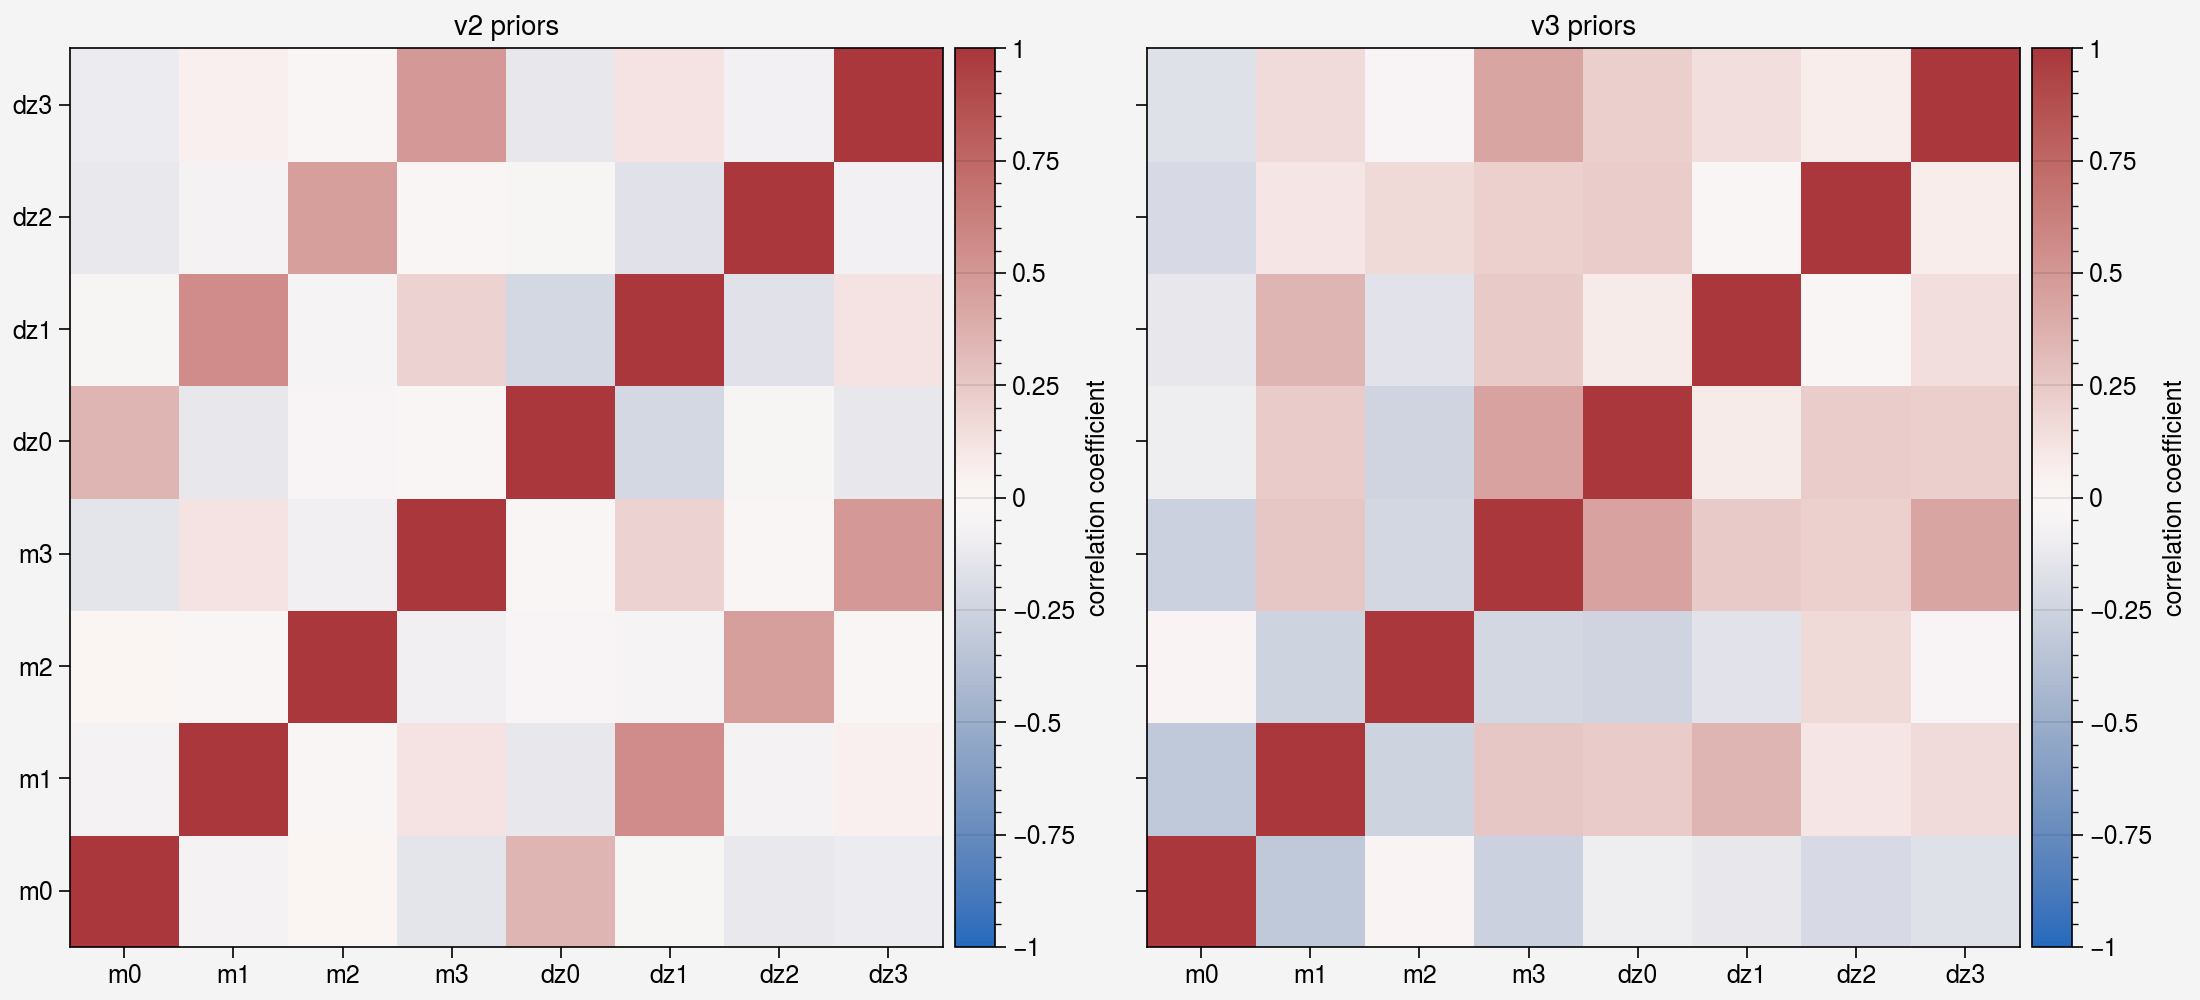

In [10]:

fig, axs = uplt.subplots(figsize=(11, 5), ncols=2, nrows=1)


for aind, adata in zip([0, 1], [v2_data, v3_data]):
    mdz = np.concatenate([adata["m"], adata["dz"]], axis=1)
    corr = np.corrcoef(mdz.T)

    ax = axs[0, aind]
    m = ax.pcolormesh(corr, vmin=-1, vmax=1, cmap="vlag", discrete=False)
    ax.colorbar(m, label="correlation coefficient")
    ax.format(
        grid=False,
        title=f"v{aind+2} priors",
        xticks=list(range(8)),
        yticks=list(range(8)),
        xticklabels=(
            [f"m{i}" for i in range(4)]
            + [f"dz{i}" for i in range(4)]
        ),
        yticklabels=(
            [f"m{i}" for i in range(4)]
            + [f"dz{i}" for i in range(4)]
        ),
    )


In [11]:
import yaml

In [13]:
with open("fit_stats_v3.1.yml", "r") as fp:
    data = yaml.load(fp, Loader=yaml.SafeLoader)

In [14]:
print("|---------------------------------------------------------|")
print("| model | data wgt.                | chi2 | dof | p-value |")
print("|---------------------------------------------------------|")
for m in ["f", "g"]:
    for key in data[m]:
        ci = data[m][key]
        print(f"| {ci['model_kind']:5} | {ci['key']:24s} | {ci['chi2']:1.2f} | {ci['dof']:3} | {ci['p_value']:0.2f}    |")
print("|---------------------------------------------------------|")

|---------------------------------------------------------|
| model | data wgt.                | chi2 | dof | p-value |
|---------------------------------------------------------|
| f     | statistical              | 7.94 |   8 | 0.44    |
| f     | statistical-neighbor     | 9.48 |   8 | 0.30    |
| f     | statistical-nz           | 5.68 |   8 | 0.68    |
| f     | statistical-occupancy    | 6.39 |   8 | 0.60    |
| g     | statistical              | 3.05 |   4 | 0.55    |
| g     | statistical-neighbor     | 3.16 |   4 | 0.53    |
| g     | statistical-nz           | 0.99 |   4 | 0.91    |
| g     | statistical-occupancy    | 3.41 |   4 | 0.49    |
|---------------------------------------------------------|
